# Fine-tuning ESM-2 for predicting protein binding sites


By [Elisa Gómez de Lope](https://elisagdelope.rbind.io/) | [Twitter](https://twitter.com/elisagdelope)

Binding sites are regions on protein surfaces where other molecules (ligands) bind, and are crucial for their function. For example, enzymes have active sites where substrates bind and undergo a chemical reaction. These sites are characterized by specific amino acid residues that interact with ligands through bonds and hydrophobic interactions. Predicting which residues in a protein are binding sites is essential for understanding protein function, drug design, and biotechnology applications, aiding in identifying therapeutic targets and understanding disease mechanisms. More about binding sites can be found in a dedicated [introductory tutorial](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Introduction_to_Binding_Sites.ipynb).

In this tutorial, you will explore the process of fine-tuning a protein language model, in particular, ESM-2, for the task of binding site prediction.

#### Table of Contents:
* [Fine-tuning a protein language model for binding site prediction: how does it work?](#introduction)
* [Data collection & processing](#data-processing)
* [Fine-tuning for binding site prediction](#finetuning)
* [Evaluation](#evaluation)
* [Inference](#inference)
* [Further reading](#reading)

This tutorial is made to run with GPU support if available (CPU otherwise), and can be used in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Fine-tuning_ESM-2_for_Binding_Sites_Prediction.ipynb)

## Fine-tuning a protein language model for binding site prediction: how does it work? <a name="introduction"></a>


ESM-2 (Evolutionary Scale Modeling) is a protein language model (pLM) using a transformer-based architecture to process protein sequences. It has been trained on large datasets of protein sequences to learn the relationships between amino acids and the structural and functional properties of proteins. Pre-trained pLMs like ESM-2 can be fine-tuned for specific "downstream tasks", such as predicting binding sites. The intuition of fine-tuning is that we can leverage the rich (but generic) representations learned by ESM-2 from the many sequences it was trained on, and "refine" them with a small dataset for a specific task.

The advantages of fine-tuning versus training a model directly for the specific task include the scalability and accuracy of transfer learning without the need for large task-specific datasets, which are often not available.

Indeed, ESM-2 has shown high accuracy in various protein prediction tasks. You can find more of ESM-2 and other transformer protein language models (pLMs) developed and released from the Meta Fundamental AI Research Protein Team (FAIR) [here](https://github.com/facebookresearch/esm).


The steps we need for fine-tuning a pLM for the task of predicting binding sites from protein sequences are as follows:
- **Data collection**: Gather a dataset of protein sequences with known binding sites. This can be obtained from databases like UniProt or PDB (Protein Data Bank).

- **Preprocessing**: Prepare the data by cleaning the sequences, encoding them appropriately, and splitting them into training and validation sets. Here we will show how to do this for UniProt data.

- **Model Selection**: Choose a pre-trained model. Here we will use the smallest version of ESM-2 (esm2_t6_8M_UR50D), trained with 6 layers and 8 Million parameters. Larger ESM-2 models are available in the Transformers library of Hugging Face, see [here](https://huggingface.co/facebook/esm2_t6_8M_UR50D).

- **Fine-Tuning**: Fine-tune the pre-trained pLM on the binding site prediction task using the prepared dataset.

- **Evaluation**: Evaluate the model's performance using metrics such as accuracy, precision, recall, and F1-score.

- **Inference**: Use the trained model to predict binding sites on new protein sequences.

Without further ado, let's get into the code!

## Setup

Let's first do the setup process for installing the necessary libraries, importing them, and creating helper functions that will aid in model training and evaluation.

In [ ]:
# install the necessary libraries
!pip install numpy
!pip install torch
!pip install scikit-learn
!pip install transformers
!pip install datasets
!pip install accelerate
!pip install deepchem

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import pickle
import xml.etree.ElementTree as ET
import deepchem as dc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    matthews_corrcoef
)
from transformers import (
    AutoModelForTokenClassification,
    AutoTokenizer,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset
from accelerate import Accelerator
from deepchem.utils import download_url, load_from_disk


If you want to save the downstream processed data or finetuned model, and you are running this notebook on Google colab, you may want to mount your google drive:

In [ ]:
# mount your google drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## Data collection and preprocessing <a name="data-processing"></a>

To illustrate the fine-tuning procedure, here we'll use a dataset from DeepChem storage that contains UniProt information from human proteins, including their sequence and corresponding binding sites labels. Later, we'll use the labels to fine-tune the pre-trained ESM-2 model to predict binding sites on the sequences.

An accompanying [tutorial](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/UniProt_Data_Preprocessing_for_Binding_Sites.ipynb) provides a guide on how to download and pre-process data from Uniprot using your own filters. The dataset form DeepChem was generated following this guide, until the splitting part, which we'll do here, as suits for this task.

Let's start by loading the data with which we'll fine-tune ESM-2:

In [ ]:
# import dataset from Deepchem aws storage
data_dir = dc.utils.get_data_dir()
dataset_file = os.path.join(data_dir, "uniprotkb_org_9606_AND_existence_1_OR_2_2024_07_22.pkl.gz")

if not os.path.exists(dataset_file):
    print('File does not exist. Downloading file...')
    download_url("https://deepchemdata.s3.us-west-1.amazonaws.com/datasets/uniprotkb_org_9606_AND_existence_1_OR_2_2024_07_22.pkl.gz")
    print('File successfully downloaded')

File does not exist. Downloading file...
File successfully downloaded


In [ ]:
# load file
data = load_from_disk(dataset_file)
data.head()

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Protein families,Sequence,Length,Binding site,Active site,Binding-Active site
16842,F6PU38,unreviewed,F6PU38_MACMU,"Lon protease homolog, mitochondrial (EC 3.4.21...",LONP1,Macaca mulatta (Rhesus macaque),Peptidase S16 family,MAASTGYVRLWGAARCWALRRPILAAAGGRVPTAAGAWLFRGRRAC...,961,523..530,855; 898,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
19516,K7AF68,unreviewed,K7AF68_PANTR,"Lon protease homolog, mitochondrial (EC 3.4.21...",LONP1,Pan troglodytes (Chimpanzee),Peptidase S16 family,MAASTGYVRLWGAARCWALRRPMLAAAGGRVPTAAGAWLLRGQRTC...,959,523..530,855; 898,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
19635,K7EJE8,unreviewed,K7EJE8_HUMAN,"Lon protease homolog, mitochondrial (EC 3.4.21...",LONP1,Homo sapiens (Human),Peptidase S16 family,MTIPDVFPHLPLIAITRNPVFPRFIKIIEVKNKKLVELLRRKVRLA...,829,393..400,725; 768,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
19636,K7EKE6,unreviewed,K7EKE6_HUMAN,"Lon protease homolog, mitochondrial (EC 3.4.21...",LONP1,Homo sapiens (Human),Peptidase S16 family,MTIPDVFPHLPLIAITRNPVFPRFIKIIEVKNKKLVELLRRKVRLA...,845,409..416,741; 784,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
21928,O64948,reviewed,LONP2_ARATH,"Lon protease homolog 2, peroxisomal (EC 3.4.21...",LON2 At5g47040 MQD22.18,Arabidopsis thaliana (Mouse-ear cress),Peptidase S16 family,MAETVELPSRLAILPFRNKVLLPGAIIRIRCTSHSSVTLVEQELWQ...,888,408..415,783; 826,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Split train/test sets

 Let's create a split of the data into training and test sets based on UniProt protein families, such that it ensures entire protein families are either in the training set or the test set. The goal is that the test set will contain completely "new" families of proteins that are not seen in the training set, so the evaluation represents the model's ability to generalize to entirely new families of proteins that it has not seen during training.

Notably, this is different from the traiditional stratified split, which aims to preserve the distribution of classes across both sets.

In [ ]:
# Get the number of distinct protein families
num_families = data['Protein families'].nunique()
print(f"Number of distinct protein families: {num_families}")

Number of distinct protein families: 2235


In [ ]:
np.random.seed(42)
def split_data_by_family(data, test_ratio=0.20):
    """
    Splits the dataset into train and test sets by entire protein families (not a family-stratified split!).

    Parameters:
    - data: pandas DataFrame containing the dataset with a 'Protein families' column.
    - test_ratio: float, the proportion of the dataset to include in the test split.

    Returns:
    - test_df: pandas DataFrame containing the test set.
    - train_df: pandas DataFrame containing the training set.
    """
    # Get unique protein families and shuffle them to randomize the selection
    unique_families = data['Protein families'].unique()
    np.random.shuffle(unique_families)

    # Loop through the shuffled families and add rows to the test set
    test_rows = []
    current_test_rows = 0
    for family in unique_families:
        family_rows = data[data['Protein families'] == family].index.tolist()
        if current_test_rows + len(family_rows) <= int(test_ratio * data.shape[0]):
            test_rows.extend(family_rows)
            current_test_rows += len(family_rows)
        else:
            # If adding the current family exceeds the target, stop adding
            break

    # Create the test and train datasets
    train_rows = [i for i in data.index if i not in test_rows]
    test_df = data.loc[test_rows]
    train_df = data.loc[train_rows]

    return test_df, train_df

test_df, train_df = split_data_by_family(data, test_ratio=0.20)
print(train_df.shape[0], test_df.shape[0])

95125 23678


So we have  95,125 and 23,678 proteins in the training and test sets, respectively.

In [ ]:
test_df.head()

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Protein families,Sequence,Length,Binding site,Active site,Binding-Active site
23608,P0C024,reviewed,NUDT7_HUMAN,Peroxisomal coenzyme A diphosphatase NUDT7 (EC...,NUDT7,Homo sapiens (Human),"Nudix hydrolase family, PCD1 subfamily",MSRLGLPEEPVRNSLLDDAKARLRKYDIGGKYSHLPYNKYSVLLPL...,238,92; 96,None,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
25785,P40386,reviewed,THI6_SCHPO,Probable thiamine biosynthetic bifunctional en...,thi4 SPAC23H4.10c,Schizosaccharomyces pombe (strain 972 / ATCC 2...,Thiamine-phosphate synthase family; Thz kinase...,MKRQIDYSLYLVTSSSLIAPGSTIERQVEEGILGGVTLVQHREKDI...,518,40..44; 72; 73; 92; 111; 137..139; 140; 173; 1...,433,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
25352,P31939,reviewed,PUR9_HUMAN,Bifunctional purine biosynthesis protein ATIC ...,ATIC PURH OK/SW-cl.86,Homo sapiens (Human),PurH family,MAPGQLALFSVSDKTGLVEFARNLTALGLNLVASGGTAKALRDAGL...,592,12..14; 34..37; 64..67; 101..102; 125..126; 20...,137; 267,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, ..."
28831,Q0VCK0,reviewed,PUR9_BOVIN,Bifunctional purine biosynthesis protein ATIC ...,ATIC PURH,Bos taurus (Bovine),PurH family,MAPGQLALFSVSDKNGLVEFARNLASVGLNLIASGGTAKALRDAGL...,592,12..14; 34..37; 64..67; 101..102; 125..126; 20...,137; 267,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, ..."
69704,O74928,reviewed,PUR9_SCHPO,Bifunctional purine biosynthesis protein ade10...,ade10 SPCPB16A4.03c,Schizosaccharomyces pombe (strain 972 / ATCC 2...,PurH family,MYALLSVYDKTGLLELAKALTSKGVKLLGSGGTAKMIRESGMEVAD...,585,30..33; 60..63; 97..98; 121..122; 200..201; 26...,133; 260,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In case you don't want to keep the entire train/test datasets, you can create a smaller version (with a random representation of the original dataset). Uncomment the code below if that is the case:

In [ ]:
# # Percentage of data you want to keep
# k = 0.05  # for keeping 5% of the data

# # Generate random indices representing a percentage of each dataset
# train_df = train_df.sample(frac=k, random_state=42)
# test_df = test_df.sample(frac=k, random_state=42)

### Split sequences into chunks

Protein sequences aren’t always of the same length. We will split the longer protein sequences and their lables into non-overlapping chunks of certain length or less to account for a given context window of ESM-2 models. Most protein sequences are on average 350 or so residues, so having longer context windows is often unnecessary, but keep in mind this will effect training time and batch size. Here, we pick a context of 1000.

In [ ]:
def split_into_chunks(sequences, labels, chunk_size = 1000):
    """Split sequences and labels into chunks of size "chunk_size" or less."""
    new_sequences = []
    new_labels = []
    for seq, lbl in zip(sequences, labels):
        if len(seq) > chunk_size:
            # Split the sequence and labels into chunks of size "chunk_size" or less
            for i in range(0, len(seq), chunk_size):
                new_sequences.append(seq[i:i+chunk_size])
                new_labels.append(lbl[i:i+chunk_size])
        else:
            new_sequences.append(seq)
            new_labels.append(lbl)

    return new_sequences, new_labels


In [ ]:
# Create lists of sequences and labels
test_seq = test_df['Sequence'].tolist()
test_labels = test_df['Binding-Active site'].tolist()
train_seq = train_df['Sequence'].tolist()
train_labels = train_df['Binding-Active site'].tolist()

In [ ]:
# Apply the function to create new datasets with chunks of size "chunk_size" or less
chunk_size = 1000
test_seq, test_labels = split_into_chunks(test_seq, test_labels, chunk_size)
train_seq, train_labels = split_into_chunks(train_seq, train_labels, chunk_size)

In [ ]:
print(len(train_seq), len(test_seq))

100386 24857


Because some protein sequences are larger than the established context window of 1000 amino acids, we have 100,386 sequences that will be used to fine-tune ESM-2's protein representations (embeddings) for the task of predicting a binding site, and 24,857 sequences that will be used for testing. Let's have a look at the data sets and labels format:

In [ ]:
print(len(train_seq[0]))
print(len(train_labels[0]))

961
961


In [ ]:
train_seq[0:3]

['MAASTGYVRLWGAARCWALRRPILAAAGGRVPTAAGAWLFRGRRACDAFPSWALWGRGPVIGGQWRGFWEANSRGGGAFSGGQDASEGGAEEGAGGAGGSAGGGEGPVITALTPMTIPDVFPHLPLIAITRNPVFPRFIKIIEVKNKKLVELLRRKVRLAQPYVGVFLKRDDNNESDVVENLDEIYHTGTFAQIHEMQDLGDKLRMIVMGHRRVHISRQLEVEPEELEAENKHKPRRKSKRGKKEAEDELSARHPTELAMEPAPELPAEVLMVEVENVVHEDFQVTEEVKALTAEIVKTIRDIIALNPLYRESVLQMMQAGQRVVDNPIYLSDMGAALTGAESHELQDVLEETNIPKRLYKALSLLKKEFELSKLQQRLGREVEEKIKQTHRKYLLQEQLKIIKKELGLEKDDKDAIEEKFRERLKELVVPKHVMDVVDEELSKLGLLDNHSSEFNVTRNYLDWLTSIPWGKYSNENLDLVRAQAVLEEDHYGMEDVKKRILEFIAVSQLRGSTQGKILCFYGPPGVGKTSIARSIARALNREYFRFSVGGMTDVAEIKGHRRTYVGAMPGKIIQCLKKTKTENPLILIDEVDKIGRGYQGDPSSALLELLDPEQNANFLDHYLDVPVDLSKVLFICTANVTDTIPEPLRDRMEMINVSGYVAQEKLAIAERYLVPQARALCGLDESKAKLSSDVLTLLIKQYCRESGVRNLQKQVEKVLRKSAYKIVSGEAESVEVTPENLQDFVGKPVFTVERMYDVTPPGVVMGLAWTAMGGSTLFVETSLRRPQDKDAKGDKDGSLEVTGQLGEVMKESARIAYTFARAFLMQHAPANNYLVTSHIHLHVPEGATPKDGPSAGCTIVTALLSLAMGRPVRQNLAMTGEVSLTGKILPVGGIKEKTIAAKRAGVTCIVLPAENKKDFYDLAAFITEGLEVHFVEHYREIFDIAFPDEQAEAEALAVER',
 'MAASTGYVRLWGAARCWALRRPMLAAAGGRVP

In [ ]:
print(train_labels[0], end="")

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

As you can see, `train_seq` and `test_seq` are lists of protein sequences, while train_labels and test_labels are lists of 0s and 1s, indicating the presence (1) or absence (0) of active binding site at the corresponding position. Notably, the data is highly unabalanced as most aminoacids in each sequence are not binding sites. These lists are the necessary information to train the model for predicting binding sites given a protein sequence. Now we are all set to start the fine-tuning!

Feel free to uncomment the following code to save the train/test and corresponding labels splits for future use.

In [ ]:
# file_path = "/content/gdrive/dataset_name.pkl"
# filename = os.path.splitext(os.path.basename(file_path))[0]
# dir = os.path.dirname(file_path)

# # Paths to save the new chunked pickle files
# test_labels_path =  os.path.join(dir, filename + "_test_labels_chunked_" + str(chunk_size) + ".pkl")
# test_seq_path = os.path.join(dir, filename + "_test_sequences_chunked_" + str(chunk_size) + ".pkl")
# train_labels_path = os.path.join(dir, filename + "_train_labels_chunked_" + str(chunk_size) + ".pkl")
# train_seq_path = os.path.join(dir, filename + "_train_sequences_chunked_" + str(chunk_size) + ".pkl")

# # Save both the entire dataset and the chunked datasets as new pickle files
# dataset.to_pickle(file_path)
# with open(test_labels_path, 'wb') as file:
#     pickle.dump(test_labels_chunked, file)
# with open(test_seq_path, 'wb') as file:
#     pickle.dump(test_seq_chunked, file)
# with open(train_labels_path, 'wb') as file:
#     pickle.dump(train_labels_chunked, file)
# with open(train_seq_path, 'wb') as file:
#     pickle.dump(train_seq_chunked, file)

# test_labels_path, test_seq_path, train_labels_path, train_seq_path

## Fine-tuning for binding site prediction <a name="finetuning"></a>


We will now create some helper functions that will be used for data preparation, metric computation, and custom loss calculation. These functions will streamline the process of training and evaluating our model.

In [ ]:
# Helper Functions and Data Preparation
def truncate_labels(labels, max_length):
    """Truncate labels to the specified max_length."""
    return [label[:max_length] for label in labels]

def compute_metrics_train(p):
    """Compute metrics for evaluation."""
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove padding (-100 labels)
    predictions = predictions[labels != -100].flatten()
    labels = labels[labels != -100].flatten()

    # Compute accuracy
    accuracy = accuracy_score(labels, predictions)

    # Compute precision, recall, F1 score, and AUC
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    auc = roc_auc_score(labels, predictions)

    # Compute MCC
    mcc = matthews_corrcoef(labels, predictions)

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc, 'mcc': mcc}

def compute_loss(model, inputs):
    """Custom compute_loss function."""
    logits = model(**inputs).logits
    labels = inputs["labels"]
    loss_fct = nn.CrossEntropyLoss(weight=class_weights)
    active_loss = inputs["attention_mask"].view(-1) == 1
    active_logits = logits.view(-1, model.config.num_labels)
    active_labels = torch.where(
        active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
    )
    loss = loss_fct(active_logits, active_labels)
    return loss


### Tokenization

Tokenizers are responsible for converting the raw protein sequences into a format or a representation that the model can understand, typically by mapping amino acids to numerical tokens. We can load a pre-trained tokenizer from the Hugging Face library. In particular, the tokenizer we will use is specific to the ESM-2 model pre-trained with 6 layers and 8 million parameters.

When calling the tokenizer, you set a maximum sequence length of residues, in this case, 1000. This is particularly important if the data has not been chunked during the preprocessing, because models have a limit on the sequence length they can process. If sequences are longer than this limit, they will be truncated, and if they are shorter, they will be padded. See more of padding and truncation at this [link](https://huggingface.co/docs/transformers/en/pad_truncation).

Finally, you want the tokenizer to return the actual tensors that will be fed to the model. Set the return_tensors parameter to either 'pt' for PyTorch, or 'tf' for TensorFlow. Here, we will use PyTorch, hence 'pt'.

In [ ]:
# Tokenization from ESM2 6 layers 8M parameters
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
max_sequence_length = 1000 # here note that data was processed with chunks (context window) of 1000 residues - adapt accordingly

train_tokenized = tokenizer(train_seq, padding=True, truncation=True, max_length=max_sequence_length, return_tensors="pt", is_split_into_words=False)
test_tokenized = tokenizer(test_seq, padding=True, truncation=True, max_length=max_sequence_length, return_tensors="pt", is_split_into_words=False)

In [ ]:
train_tokenized

{'input_ids': tensor([[ 0, 20,  5,  ...,  1,  1,  1],
        [ 0, 20,  5,  ...,  1,  1,  1],
        [ 0, 20, 11,  ...,  1,  1,  1],
        ...,
        [ 0, 10, 12,  ...,  1,  1,  1],
        [ 0, 20,  8,  ...,  1,  1,  1],
        [ 0, 20,  4,  ...,  1,  1,  1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

The tokenizer returns a dictionary with two items:

- input_ids: are the indices corresponding to each token in the sentence.
- attention_mask: indicates whether a token should be attended to or not.

In [ ]:
print(train_seq[0])
encoded_input = tokenizer(train_seq[0])
print(encoded_input)

MAASTGYVRLWGAARCWALRRPILAAAGGRVPTAAGAWLFRGRRACDAFPSWALWGRGPVIGGQWRGFWEANSRGGGAFSGGQDASEGGAEEGAGGAGGSAGGGEGPVITALTPMTIPDVFPHLPLIAITRNPVFPRFIKIIEVKNKKLVELLRRKVRLAQPYVGVFLKRDDNNESDVVENLDEIYHTGTFAQIHEMQDLGDKLRMIVMGHRRVHISRQLEVEPEELEAENKHKPRRKSKRGKKEAEDELSARHPTELAMEPAPELPAEVLMVEVENVVHEDFQVTEEVKALTAEIVKTIRDIIALNPLYRESVLQMMQAGQRVVDNPIYLSDMGAALTGAESHELQDVLEETNIPKRLYKALSLLKKEFELSKLQQRLGREVEEKIKQTHRKYLLQEQLKIIKKELGLEKDDKDAIEEKFRERLKELVVPKHVMDVVDEELSKLGLLDNHSSEFNVTRNYLDWLTSIPWGKYSNENLDLVRAQAVLEEDHYGMEDVKKRILEFIAVSQLRGSTQGKILCFYGPPGVGKTSIARSIARALNREYFRFSVGGMTDVAEIKGHRRTYVGAMPGKIIQCLKKTKTENPLILIDEVDKIGRGYQGDPSSALLELLDPEQNANFLDHYLDVPVDLSKVLFICTANVTDTIPEPLRDRMEMINVSGYVAQEKLAIAERYLVPQARALCGLDESKAKLSSDVLTLLIKQYCRESGVRNLQKQVEKVLRKSAYKIVSGEAESVEVTPENLQDFVGKPVFTVERMYDVTPPGVVMGLAWTAMGGSTLFVETSLRRPQDKDAKGDKDGSLEVTGQLGEVMKESARIAYTFARAFLMQHAPANNYLVTSHIHLHVPEGATPKDGPSAGCTIVTALLSLAMGRPVRQNLAMTGEVSLTGKILPVGGIKEKTIAAKRAGVTCIVLPAENKKDFYDLAAFITEGLEVHFVEHYREIFDIAFPDEQAEAEALAVER
{'input_ids': [0, 20, 5, 5, 8, 11, 6, 

In [ ]:
tokenizer.decode(encoded_input["input_ids"])

'<cls> M A A S T G Y V R L W G A A R C W A L R R P I L A A A G G R V P T A A G A W L F R G R R A C D A F P S W A L W G R G P V I G G Q W R G F W E A N S R G G G A F S G G Q D A S E G G A E E G A G G A G G S A G G G E G P V I T A L T P M T I P D V F P H L P L I A I T R N P V F P R F I K I I E V K N K K L V E L L R R K V R L A Q P Y V G V F L K R D D N N E S D V V E N L D E I Y H T G T F A Q I H E M Q D L G D K L R M I V M G H R R V H I S R Q L E V E P E E L E A E N K H K P R R K S K R G K K E A E D E L S A R H P T E L A M E P A P E L P A E V L M V E V E N V V H E D F Q V T E E V K A L T A E I V K T I R D I I A L N P L Y R E S V L Q M M Q A G Q R V V D N P I Y L S D M G A A L T G A E S H E L Q D V L E E T N I P K R L Y K A L S L L K K E F E L S K L Q Q R L G R E V E E K I K Q T H R K Y L L Q E Q L K I I K K E L G L E K D D K D A I E E K F R E R L K E L V V P K H V M D V V D E E L S K L G L L D N H S S E F N V T R N Y L D W L T S I P W G K Y S N E N L D L V R A Q A V L E E D H Y G M E D V

In [ ]:
print(len(train_seq[0]), len(encoded_input["input_ids"]))

961 963


You may have noticed that the tokenizer has added two special tokens - '< cls >' and '< eos >' (classifier and separator) - to the sentence. This is why the length of *encoded_input* is 2 items larger than the original sequence. Not all models need special tokens, but if they do, the tokenizer automatically adds them for you.

Now the embeddings (or tokenized/encoded sequences) and the attention masks are tensors, ready to be fed to the model. The labels need to be truncated correspondingly, and we add them to the train_tokenized and test_tokenized dictionaries, which will be used to feed data into the model during the training and testing phases.

In [ ]:
# Directly truncate the entire list of labels
train_labels = truncate_labels(train_labels, max_sequence_length)
test_labels = truncate_labels(test_labels, max_sequence_length)

train_dataset = Dataset.from_dict({k: v for k, v in train_tokenized.items()}).add_column("labels", train_labels)
test_dataset = Dataset.from_dict({k: v for k, v in test_tokenized.items()}).add_column("labels", test_labels)

### Training

The class AutoModelForTokenClassification from the Hugging Face library has been designed for token classification tasks. Token classification involves assigning a label to each token in the input sequence. In the context of protein sequences, each token corresponds to an amino acid residue.

We load the pre-trained ESM-2 model with 6 layers and 8 million parameters. The model has already been trained on a large dataset and can be fine-tuned for specific tasks with less training data. This allows the model to adapt to the nuances of the task while leveraging the general features it has already learned.

The model will be fine-tuned to classify each residue in the sequence as either a binding site or a non-binding site, leveraging the powerful features learned during pre-training. In this case, the classification is binary, so there are 2 labels corresponding to "binding site" and "non-binding site" residues.

In [ ]:
model = AutoModelForTokenClassification.from_pretrained("facebook/esm2_t6_8M_UR50D", num_labels=2)

Some weights of EsmForTokenClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Let's configure the training process. Through the class TrainingArguments one ca define aspects such as where to save the model, how often to evaluate, and which metric to use for selecting the best model, among others.

Here we define the evaluation to happen at the end of each epoch to monitor the model's performance and making adjustments if necessary. The model will also be saved at the end of each epoch so that there are checkpoints to revert to in case of any issues during training.

Choosing an appropriate metric to optimize the model for is crucial for model evaluation. The F1 score is a good choice for classification tasks, especially when dealing with imbalanced classes, but feel free to explore others like AUC or accuracy.

Defining this kind of configuration setup ensures that you have a robust and reproducible training pipeline for your ESM-2 model, and helps the training process to be well-organized, with checkpoints and evaluations at each epoch, and the best model is selected based on the F1 score.

In [ ]:
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
training_args = TrainingArguments(
    output_dir=f"/content/gdrive/MyDrive/ESMbind/data/trained_models/esm2_t6_8M-binding-sites_{timestamp}",
    seed=42,
    num_train_epochs = 3,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_dir=f"/content/gdrive/MyDrive/ESMbind/data/trained_logs/esm2_t6_8M-binding-sites_{timestamp}",
    logging_strategy="steps",
    logging_steps=10,
    save_total_limit=5,
    fp16=True,
    report_to="none"  # Disable wandb
)


We will make use of the class Trainer from the 🤗 Transformers library to train (finetune) the pre-trained ESM-2 model. This class is optimized for training 🤗 Transformers models, making it easier to start training without manually writing your own training loop.


In the Trainer object, model performance is not automatically evaluated during training. You’ll need to pass Trainer a function to compute and report metrics. We define a function to set up a comprehensive evaluation framework to assess the model's performance. This includes computing various evaluation metrics for the model's predictions, including accuracy, precision, recall, F1, AUC and MCC.

In [ ]:
def compute_metrics_train(eval_pred):
    """Compute metrics for evaluation."""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    # Remove padding (-100 labels)
    predictions = predictions[labels != -100].flatten()
    labels = labels[labels != -100].flatten()

    # Compute accuracy
    accuracy = accuracy_score(labels, predictions)

    # Compute precision, recall, F1 score, and AUC
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    auc = roc_auc_score(labels, predictions)

    # Compute MCC
    mcc = matthews_corrcoef(labels, predictions)

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc, 'mcc': mcc}

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics_train,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer=tokenizer)

)

Most arguments of the Trainer instance have been already defined and explained. The DataCollatorForTokenClassification class is used to collate batches of data for token classification tasks. It ensures that the input data is properly formatted and padded for the model.

Now we are all set to start the training. Mind that this can take a few hours, feel free to reduce the number of epochs to reduce training time.

In [ ]:
trainer.train()

Let's save the trained model's weights and configuration, so we can reload the model later for inference or further training. You may also want to save the tokenizer, which is needed for preprocessing the sequence data in the same way it was done during training, ensuring consistency when the model is used later.

In [ ]:
# Save Model
save_path = os.path.join("/content/gdrive/MyDrive/ESMbind/results/binding_sites", f"best_model_esm2_t6_8M_{timestamp}")
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

('/content/gdrive/MyDrive/ESMbind/results/binding_sites/best_model_esm2_t6_8M_2024-06-24_09-43-05/tokenizer_config.json',
 '/content/gdrive/MyDrive/ESMbind/results/binding_sites/best_model_esm2_t6_8M_2024-06-24_09-43-05/special_tokens_map.json',
 '/content/gdrive/MyDrive/ESMbind/results/binding_sites/best_model_esm2_t6_8M_2024-06-24_09-43-05/vocab.txt',
 '/content/gdrive/MyDrive/ESMbind/results/binding_sites/best_model_esm2_t6_8M_2024-06-24_09-43-05/added_tokens.json')

## Evaluation <a name="evaluation"></a>

Now we can load the finetuned model and check its performance. An Accelerator object is created to handle device placement and optimizations for the available hardware.

In [ ]:
# Load the tuned model
tuned_model_path = "/content/gdrive/MyDrive/ESMbind/results/binding_sites/best_model_esm2_t6_8M_2024-06-24_09-43-05" # select the tuned model you want to evaluate
tuned_model = AutoModelForTokenClassification.from_pretrained(tuned_model_path)
accelerator = Accelerator()
model = accelerator.prepare(tuned_model)  # Prepare the model using the accelerator

Now we create a mapping to convert between the format used by the model (numerical IDs) and a more interpretable format (labels):
- 0 is mapped to "No binding site".
- 1 is mapped to "Binding site".

In [ ]:
# Define label mappings
id2label = {0: "No binding site", 1: "Binding site"}
label2id = {v: k for k, v in id2label.items()}

# Create a data collator
data_collator = DataCollatorForTokenClassification(tokenizer)


 Similar as for training, a DataCollatorForTokenClassification instance is created using the tokenizer to handle batching and padding of input sequences during evaluation, ensuring that the data is in the correct format for the model.

 Now we can create a function to compute evaluation metrics for a model's predictions on a given dataset. This function *compute_metrics_dataset* is similar to the previously defined function *compute_metrics_train*, only that *compute_metrics_train* is designed to be used directly with predictions and labels, typically during the training process, while *compute_metrics_dataset* is designed to be used with a Trainer object to make predictions on a dataset and then compute evaluation metrics. It handles the entire process from making predictions to computing metrics.

In [ ]:
# Define a function to compute the metrics for evaluation
def compute_metrics_dataset(dataset):
    # Get the predictions using the trained model
    trainer = Trainer(model=model, data_collator=data_collator)
    predictions, labels, _ = trainer.predict(test_dataset=dataset)

    # Remove padding and special tokens
    mask = labels != -100
    true_labels = labels[mask].flatten()
    flat_predictions = np.argmax(predictions, axis=2)[mask].flatten().tolist()

    # Compute the metrics
    accuracy = accuracy_score(true_labels, flat_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, flat_predictions, average='binary')
    auc = roc_auc_score(true_labels, flat_predictions)
    mcc = matthews_corrcoef(true_labels, flat_predictions)  # Compute the MCC

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "auc": auc, "mcc": mcc}  # Include the MCC in the returned dictionary


Now we can get the metrics for the training and test datasets. Mind that this takes a long time, particularly the training set metrics.

In [ ]:
train_metrics = compute_metrics_dataset(train_dataset)
test_metrics = compute_metrics_dataset(test_dataset)
train_metrics, test_metrics

## Inference <a name="inference"></a>

For making inferences, i.e., predictions on the binding sites of new protein sequences, you need to load the tuned model you wish to use for inference, and set it to evaluation mode to ensure consistent behavior during inference.

In [ ]:
tuned_model_path = "/content/gdrive/MyDrive/ESMbind/results/binding_sites/Am_esm2_t6_8M_general_binding_sites_v2" # select your tuned model
tuned_model = AutoModelForTokenClassification.from_pretrained(tuned_model_path)
accelerator = Accelerator()
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
tuned_model = accelerator.prepare(tuned_model)

In [ ]:
# Ensure the model is in evaluation mode
tuned_model.eval()

EsmForTokenClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 320, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 320, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=320, out_features=320, bias=True)
              (key): Linear(in_features=320, out_features=320, bias=True)
              (value): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((320,), eps=1e-05, el

Now we are all set to infer binding sites on new sequences and get the predicted labels for each token in the sequence. For this purpose, the new sequence is tokenized, and the model is run to get the logits (i.e., the results of the model for each token), which are converted to the predicted labels (0 for non-binding, 1 for binding site in this case).


In [ ]:
def infer_binding_sites(sequence, tokenizer, accelerator):
   # Tokenize the sequence
  tokenized_sequence = tokenizer(sequence, return_tensors="pt", truncation=True, max_length=1024, padding='max_length')

  # Move the tokenized sequence to the same device through the accelerator
  tokenized_sequence = {key: value.to(accelerator.device) for key, value in tokenized_sequence.items()}
  tokens = tokenizer.convert_ids_to_tokens(tokenized_sequence["input_ids"][0])  # Convert input ids back to tokens (aminoacids in this case, but also special tokens generated by the tokenizer)

  # Run the model
  with torch.no_grad():
      logits = tuned_model(**tokenized_sequence).logits

  # Get predictions
  predictions = torch.argmax(logits, dim=2)
  predictions = predictions[0].cpu().numpy()

  # Filter out predictions corresponding to special tokens
  special_tokens = [tokenizer.pad_token, tokenizer.cls_token, tokenizer.sep_token, tokenizer.eos_token]
  special_tokens = [token for token in special_tokens if token is not None]  # Remove None tokens
  filtered_predictions =[]
  for token, pred in zip(tokens, predictions):
    if token not in special_tokens:
      filtered_predictions.append(pred)

  # Check for matching length of predictions and sequence
  if len(filtered_predictions) != len(sequence):
      error_message = (
          f"Error: Length mismatch! Sequence length: {len(sequence)}, "
          f"Filtered predictions length: {len(filtered_predictions)}. "
          "This could be due to unaccounted special tokens in the tokenizer."
      )
      raise ValueError(error_message)
  return filtered_predictions

Observe that in the *infer_binding_sites* function, the predictions are aligned with the tokenized sequence, which may contain padding and other special tokens, and not necessarily (indeed, most likely not) only the sequence. So the predictions corresponding to the special tokens need to be removed, if we want to then match those predictions with the input sequence directly (i.e., predictions are of the same length as the sequence).

In [ ]:
# Define function to highlight binding sites by displaying binding sites among brakets within the sequence:
def braket_binding_sites(protein_sequence, labels):
  """
  Highlights binding sites within a given protein sequence by displaying binding sites among brakets within the sequence
  """
  labeled_sequence = []
  # Print the predicted labels for each token
  for aa, prediction in zip(protein_sequence, predictions):
    if prediction == 1:
        labeled_sequence.append(f"[{aa}]")
    else:
        labeled_sequence.append(aa)
  return "".join(labeled_sequence)

Let's make inferences! For an illustrative example, we show here a well-studied protein: the C-ABL tyrosine kinase. This protein is known to bind to the drug Imatinib (Gleevec), so we can see if the fine-tuned ESM-2 model identifies the binding sites in the C-ABL kinase sequence.

The PDB ID for this complex is '1IEP', from which we can extract both the chrystalized structure and the sequence.

In [ ]:
# Protein sequence for inference
protein_sequence = "MDPSSPNYDKWEMERTDITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVSAVVLLYMATQISSAMEYLEKKNFIHRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQ"#"MAVPETRPNHTIYINNLNEKIKKDELKKSLHAIFSRFGQILDILVSRSLKMRGQAFVIFKEVSSATNALRSMQGFPFYDKPMRIQYAKTDSDIIAKMKGT"
predictions = infer_binding_sites(protein_sequence, tokenizer, accelerator)

# Display sequence with identified binding sites
id_sequence = braket_binding_sites(protein_sequence, predictions)
print("Sequence: ", id_sequence)


Sequence:  MDPSSPNYDKWEMERTDITMKH[K][L][G][G][G][Q][Y][G][E]VYEGVWKKYSLTVA[V]KTLKEDTMEVEEFLKEAAVMKEIKHPNLVQLLGVCTREPPFYI[I][T][E][F][M][T][Y][G][N]LLDYLRECNRQEVSAVVLLYMATQISSAMEYLEKKNFIHRDLA[A][R]NCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKSDVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNPSDRPSFAEIHQAFETMFQ


Some binding sites were identified, that's great! Let's now visualize the protein structure highlighting the identified binding sites vs the real binding sites (ground truth).

### Visualization

In [ ]:
# setup for the visualization
!pip install py3Dmol biopython requests
import requests
import py3Dmol
from Bio.PDB import PDBParser, NeighborSearch
from io import StringIO

In [ ]:
# Download the protein-ligand complex (PDB file)
pdb_id = "1IEP"
url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
response = requests.get(url)
pdb_content = response.text

The structure in 1IEP is a homodimer of two identical chains A and B, and STI is the ligand of interest (Imatinib). For visualization, let's extract the information of chain A and STI:

In [ ]:
chain_id = "A"
chain_lines = []
for line in pdb_content.splitlines():
    if line.startswith("HETATM") or line.startswith("ATOM"):
        if line[21] == chain_id:
            chain_lines.append(line)
    elif line.startswith("TER"):
        if chain_lines and chain_lines[-1][21] == chain_id:
            chain_lines.append(line)
chain_A = "\n".join(chain_lines)

In [ ]:
parser = PDBParser()
structure = parser.get_structure('protein', StringIO(pdb_content))

# Extract residues of chain A and the ligand STI
str_chain_A = structure[0][chain_id]
ligand = None
ligand_resname = "STI"
for residue in structure.get_residues():
    if residue.id[0] != ' ' and residue.resname == ligand_resname:
        ligand = residue
        break
if ligand is None:
    raise ValueError("Ligand STi not found in the PDB content")

chain_A_atoms = [atom for atom in str_chain_A.get_atoms()]
ligand_atoms = [atom for atom in ligand.get_atoms()]

/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5038.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5079.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5118.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5217.
  warnings.warn(


Now we'll define the binding pocket as those residues within a 5Å range of the atoms of the ligand.

In [ ]:
# Extract residues with atoms in a 5Å range of the ligand atoms (binding pocket)
binding_residues = set()
distance_threshold = 5.0
ns = NeighborSearch(chain_A_atoms)

for ligand_atom in ligand_atoms:
    close_atoms = ns.search(ligand_atom.coord, distance_threshold)
    for atom in close_atoms:
        binding_residues.add(atom.get_parent().id[1])

In order to visualize the predicted binding residues from the predictions onto the structure, one needs to get their indexes in the sequence and map them to residue numbers from the PDB structure. Then, we can identify those predicted residues that are in the binding pocket defined as the 5Å range around the STI ligand.

In [ ]:
# Get predicted binding sites residues indices
#np.where(np.array(predictions) == 1)[0]
pred_binding_sites_indexes = [index for index, label in enumerate(predictions) if label == 1]

# Map predicted binding site indices to residue numbers
pred_residues = [residue.id[1] for residue in str_chain_A.get_residues()]
pred_binding_sites_residues = [pred_residues[i] for i in pred_binding_sites_indexes]

# intersect residues that are both predicted bingin sites and in the 5Å binding pocket
common_residues = [resi for resi in pred_binding_sites_residues if resi in binding_residues]
print("{}% of predicted binding sites are in the {}Å binding pocket".format(round(len(common_residues) / len(pred_binding_sites_residues)*100,2), int(distance_threshold)))

47.62% of predicted binding sites are in the 5Å binding pocket


Now let's see what the structure, the binding pocket, and the predicted residues look like in 3D:

In [ ]:
view = py3Dmol.view()
view.addModel(chain_A, "pdb")

# Set style for the protein
view.setStyle({'cartoon': {'color': 'darkgreen'}})

# Magenta for residues that are both predicted binding sites and in the 5Å binding pocket
for resi in common_residues:
  view.addStyle({'chain': chain_id, 'resi': [resi]}, {'cartoon': {'color': 'magenta'}})

# Red for residues predicted as binding sites not in the binding pocket
for pred_resi in pred_binding_sites_residues:
  if pred_resi not in common_residues:
    view.addStyle({'chain': chain_id, 'resi': [pred_resi]}, {'cartoon': {'color': 'red'}})

# Light green for the binding pocket residues
for resi in binding_residues:
  if resi not in common_residues:
    view.addStyle({'chain': chain_id, 'resi': str(resi)}, {'cartoon': {'colorscheme': 'greenCarbon'}})

# Yellow for the ligand
view.addStyle({'chain': chain_id, 'resn': ligand_resname}, {'stick': {'colorscheme': 'yellowCarbon'}})

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In case the py3Dmol visualization does not load, this is what you should be looking at:

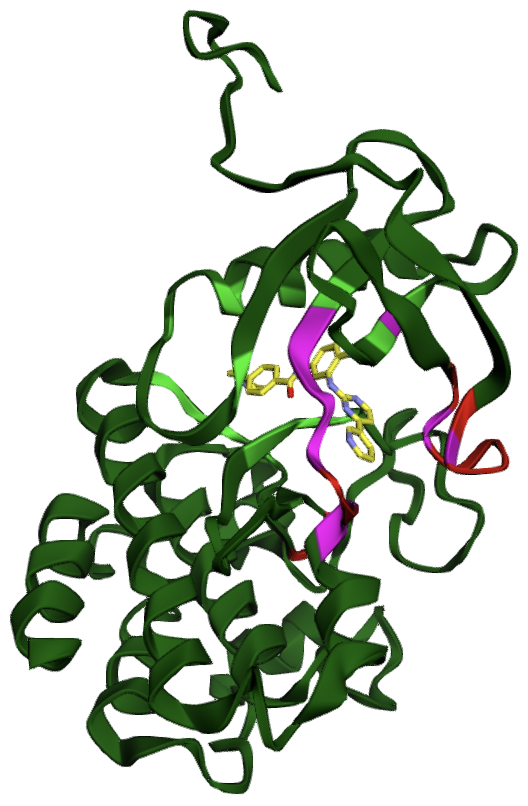

We observe that 47.62% of predicted binding sites are in the 5Å binding pocket (magenta-colored), while the other binding sites are not in that range (red-colored). This indicates that almost half of the predicted binding sites for the protein C-ABL tyrosine kinase were in the 5 Å binding pocket of Imatinib. The other predicted binding sites that fall outside the 5Å binding pocket are however in the surrounding area of one of the arms of the binding site (i.e., not randomly distributed across the sequence), which is a good indicator that the finetuned protein representation does a fair job in approaching the binding pocket of this protein. There is a side of the binding pocket that was not predicted by the fine-tuned ESM2 though (light green-colored).

Notably, while defining the binding pocket of a protein as the region within a certain distance (e.g., 5 Å) from the bound ligand is a common approach, it's not always a fair assumption (e.g., the cutoff is arbitrary, pocket shapes and size may vary, and residues might influence binding through indirect interactions as well). The performance metrics of the fine-tuned model should be computed with the data from the test set, as seen before.


## Further reading <a name="reading"></a>


In this tutorial we have used the ESM-2 pre-trained protein language model to generate general representations of protein sequences, we have fine-tuned these representations for the particular downstream task of identifying protein binding sites, including training and evaluation, and finally we have illustrated the use case with the inference of binding sites in the protein [C-ABL tyrosine kinase](https://www.rcsb.org/structure/1IEP), a well studied protein that is known have a binding pocket for Imatinib ligand. We used sequences and their binding sites from [UniProt](https://www.uniprot.org/), and a detailed guide on how to obtain and pre-process UniProt data through an [accompanying tutorial](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/UniProt_Data_Preprocessing_for_Binding_Sites.ipynb).

For further reading on other computational methods for binding sites with which you may want to compare the ESM-2 fine-tuned model, or more generally learning about protein language models here are a couple of great resources:

- [Exploring the computational methods for protein-ligand binding site prediction](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7049599/)

- [Getting started with protein language models](https://elisagdelope.rbind.io/post/plms/)



# Congratulations! Time to join the Community!
Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:


## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.


## Join the DeepChem Discord
The DeepChem [Discord](https://discord.gg/cGzwCdrUqS) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

# Citing this tutorial
If you found this tutorial useful please consider citing it using the provided BibTeX.




```
@manual{ProteinLanguageModels,
 title={Fine-tuning ESM-2 for binding sites prediction},
 organization={DeepChem},
 author={Gómez de Lope, Elisa},
 howpublished = {\url{https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Fine-tuning_ESM-2_for_Binding_Sites_Prediction.ipynb}},
 year={2024},
}
```